# Imports

In [2]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit_nature.transformers import FreezeCoreTransformer


# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-27 11:29:36,344: Credentials are already in use. The existing account in the session will be replaced.


# 1. Initializing the atomic structure of LiH using PySCF driver¶



First we initialize the LiH molecule (this code was already provided in the exercise) in the most stable configuration of inter-atomic distance i.e. at 1.5474Å between the Li and H atoms.

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers. There are multiple drivers available: PSI4Driver, PyQuanteDriver, PySCFDriver.

We will be running PySCFDriveron the molecule to obtain a QMolecule data class which will contain the driver result.

In [3]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [4]:
print("No. of Electrons: {}".format(qmolecule.num_alpha + qmolecule.num_beta))
print("No. of Molecular Orbitals: {}".format(qmolecule.num_molecular_orbitals))
print("No. of Spin Orbitals: {}".format(2 * qmolecule.num_molecular_orbitals))
print("No. of Qubits Needed: {}".format(2 * qmolecule.num_molecular_orbitals))
print("Nuclear Repulsion Energy: {}".format(qmolecule.nuclear_repulsion_energy))

No. of Electrons: 4
No. of Molecular Orbitals: 6
No. of Spin Orbitals: 12
No. of Qubits Needed: 12
Nuclear Repulsion Energy: 1.0259348796432726


# 2. Electronic structure problem

You can then create an ElectronicStructureProblem that can produce the list of fermionic operators before mapping them to qubits (Pauli strings).
We will reduces the QMolecule by removing some molecular orbitals which don't contribute much using FreezeCoreTransformer
The core of the molecule is frozen to reduce the number of qubits and orbitals 3 and 4 are removed as they do not contribute much to the resulting ground state energy.

Identifying the orbitals that can savely be removed while retaining the desired ground energy up to the required precision was a key factor here.

In [5]:
freezeCoreTransform=FreezeCoreTransformer(True,[4,3])
# specify problem and freeze transformation
problem = ElectronicStructureProblem(driver,[freezeCoreTransform])
# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]


# 3. QubitConverter

Allows to define the mapping that you will use in the simulation. There are different mapping available but we will be using ParityMapper as we will be doing two_qubit_reduction and z2symmetry to reduce the no. of qubits as low as possible.
In case the core is frozen, orbitals 3 and 4 are frozen, and parity mapping with two-qubit reduction is chosen, there is one symmetry that can be exploited to reduce the problem size.

In [6]:
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True,z2symmetry_reduction=[1])


# 4. Generating the initial state

Then, we finally generate our qubit operators which are derived from the fermionic operators after this whole conversion procedure. The variable qubit_op stores the qubit operators as an array of spare pauli operations applied to initialise the qubits into the proper state corresponding to the quantum wavefunction of the $LiH$ molecule.

In [7]:
# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

For generating the initial state, we resort to the Hartree-Fock perturbation theory in order to approximate the qubit operator qubit_op as a string of Pauli gates that can be applied to initialize the state of the system.

We can achieve this by using the HartreeFock class found in the qiskit_nature.circuit.library package like so,

In [8]:
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)


# 5. Ansatz¶


One of the most important choices is the quantum circuit that you choose to approximate your ground state. Here is the example of qiskit circuit library that contains many possibilities for making your own circuit.


The ansatz used was TwoLocal, with rotation layers as ['ry', 'rz'] entanglement gate was only cx, linear type of entanglement, repetitions set to 1. Idea was to get maximum entanglement with minimum circuit depth, all the while satisfying the costs.

First it started out with initial TWoLocal provided, then i tried to used different rotation layers which didn't impact performance signifiicantly.
Then i started to decrease repetition graduly and experimented with different entanglment types and optimizers


1- At first i tried Z2symmetries + two qubit reduction with 5 repetition layers, which achieved around 140 cnot

2- tried to decrease number of repetition to 3, with  SLSQP optimizers, which decreased number of cnot to 12

3- tried to experiment with freeze core and orbital removal, with different optimizers, which decreased number of cnot to 6

4- finally experimenting with shape of entaglment achieved, circular achieved 4 cnot, linear to 3 cnot



In [9]:
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry','rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

In [10]:
print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├»
        ├───┤    ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤»
q_1: ───┤ X ├────┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐     └──────────┘»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├────────────────────┤ X ├──────────■──────»
     ├──────────┤├──────────┤                    └───┘        ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─────────────────────────────────┤ X ├────»
     └──────────┘└──────────┘                                 └───┘    »
«                               
«q_0: ──────────────────────────
«     ┌───────────┐             
«q_1: ┤ RZ(θ[13]) ├─────────────
«     ├───────────┤┌───────────┐
«q_2: ┤ RY(θ[10]) ├┤ RZ(θ[14]) ├
«     ├───────────┤├───────────┤
«q_3: ┤ RY(θ[11]) ├┤ RZ(θ[15]) ├
«     └───────────┘└───────────┘


# 6. Backend

This is where you specify the simulator or device where you want to run your algorithm. We will focus on the statevector_simulator in this challenge.

In [11]:
backend = Aer.get_backend('statevector_simulator')


# 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU. A clever choice might reduce drastically the number of needed energy evaluations.

In [12]:
optimizer_type = 'SLSQP'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=5000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=5000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=5000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=10000)

# 8. Exact eigensolver

For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE. Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so you can try doing this for a large molecule of your choice and see how slow this becomes. For very large systems you would run out of memory trying to store their wavefunctions.

In [13]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0887060157347401
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


# 9. VQE and initial parameters for the ansatz

Now we can import the VQE class and run the algorithm.



In [14]:
# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []
# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

In [15]:
algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 786,
    'eigenstate': array([ 1.39110316e-03+1.62887433e-04j, -4.80366475e-03-1.47019740e-04j,
        2.62453675e-02+8.47807400e-04j, -9.91330358e-01+1.36785569e-02j,
       -5.37456330e-02-3.77354828e-03j, -3.69327924e-04-8.90831896e-05j,
        8.79309002e-04-4.45908562e-06j, -2.32775854e-02+1.49204758e-03j,
       -2.67383724e-03-7.05515028e-05j, -1.12000470e-05-8.31985413e-06j,
        3.66946989e-06+2.34907335e-05j,  3.09840633e-04-9.10960983e-04j,
        1.13572109e-01-2.69477801e-03j,  5.55557699e-04+1.40856940e-04j,
       -5.49397255e-04+3.83202710e-05j, -2.96132153e-05-1.93825304e-05j]),
    'eigenvalue': -1.0863472026328,
    'optimal_parameters': {   ParameterVectorElement(θ[11]): 0.44245607340999576,
                              ParameterVectorElement(θ[14]): -0.0501469987725114,
                              ParameterVectorElement(θ[13]): -0.04486645057712711,
                              ParameterVect

# 10. Scoring function

We need to judge how good are your VQE simulations, your choice of ansatz/optimizer. For this, we implemented the following simple scoring function:

$$ score = N_{CNOT}$$
where $N_{CNOT}$ is the number of CNOTs. But you have to reach the chemical accuracy which is $\delta E_{chem} = 0.004$ Ha $= 4$ mHa, which may be hard to reach depending on the problem. You have to reach the accuracy we set in a minimal number of CNOTs to win the challenge. The lower the score the better!

In [16]:
# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

In [17]:
print('Ansatz used: ', result_dict['ansatz'])
print('Number of parameters: ', result_dict['# of parameters'])
print('VQE Energy: ', result_dict['energy (Ha)'])
print('Error: ', result_dict['error (mHa)'])
print('Pass/Fail: ', result_dict['pass'])
print('CNOT score: ', result_dict['score'])

Ansatz used:  TwoLocal
Number of parameters:  16
VQE Energy:  -1.0863472026328
Error:  2.3588131019400826
Pass/Fail:  True
CNOT score:  3


,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,TwoLocal,4,16,"[ry, rz]",cx,linear,1,2.358813,True,3


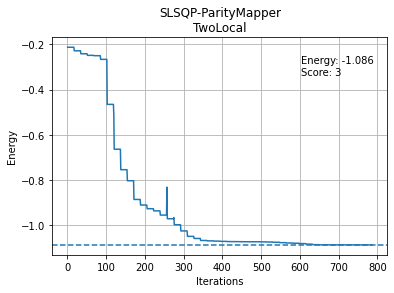

In [18]:
# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

# 11. Grading

In [19]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

